## Tutorial for kernel DEEF

This document is a Python tutorial to analyze the dissimilarity of scRNA-seq data using the kernek DEEF method.

In [1]:
#Import modules
import pandas as pd
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt

## Prepare your data

The sample data is the expression array with cell * gene * subject and labels of subjects.

In [2]:
#load data
dat = np.load("uc_data.npy") #array with 672 cell * 876 gene * 15 subject
y_labels = pd.read_csv("true_lab.csv",index_col=0).values[:,0] #labels of subjects
ncores = 2 #number of cores of parallel computing

## Calculate inner product matrix among subjects

In [3]:
#Define the function for paralell computing
def kernel_ip(sample_idx, cellmararray):
    data1 = cellmararray[:,:,sample_idx]
    n1 = cellmararray.shape[0]
    p = cellmararray.shape[1]
    nn = cellmararray.shape[2]
    gamma = 1/p
    ip_row = np.zeros(nn)
    for j in range(sample_idx, nn):
        data2 = cellmararray[:,:,j]
        n2 = data2.shape[0]
        ip_vec = np.zeros(n1)
        for i in range(n1):
            ip_vec[i] = np.exp((((data2 - data1[i,])**2).sum(axis=1))*(-gamma)).sum()
        ip_row[j] = ip_vec.sum()/(n1*n2)
    return(ip_row)

def wrapper_kernel_ip(args):
    return kernel_ip(args, cellmararray=dat)

#calculation
fn = len(y_labels) # number of subjects
with Pool(processes=ncores) as pro:
        res = pro.map(wrapper_kernel_ip,range(fn))

ip_mat = np.zeros([fn,fn])
for i in range(len(res)):
    ip_mat[i,:] = res[i]
ip_mat2 = np.zeros([fn, fn])
for i in range(fn):
    for j in range(i,fn):
        ip_mat2[i,j] = ip_mat[i,j]
        ip_mat2[j,i] = ip_mat[i,j]

## Calculate theta coordinates matrix based on subjects by subjects inner product matrix

In [4]:
#Decomposition of inner product matrix
def deef(ip_mat):
    ip_mat = np.asarray(ip_mat)
    theta_ip_est_mat = np.log(ip_mat)/2
    eigen_value, V = np.linalg.eig(theta_ip_est_mat)
    Sigma = np.diag(np.sqrt(np.abs(eigen_value)))
    Theta_all = np.dot(V, Sigma)
    res = [Theta_all, eigen_value]
    return(res)

Theta_all, eigen_value = deef(ip_mat2)
Theta = Theta_all[:,eigen_value>=0]

## Visualization of the difference among single cell expression profiles

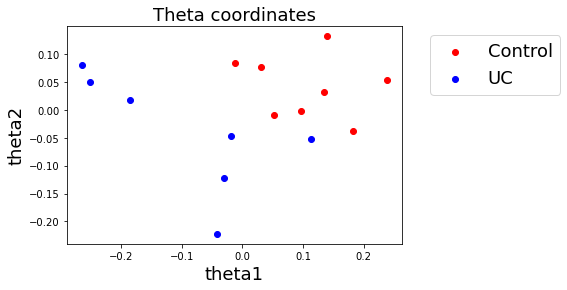

In [5]:
fig = plt.figure()
plt.scatter(Theta[y_labels == "C", 0], Theta[y_labels == "C", 1], color="red", label="Control")
plt.scatter(Theta[y_labels == "U", 0], Theta[y_labels == "U", 1], color="blue", label="UC")
plt.title("Theta coordinates", fontsize=18)
plt.xlabel("theta1", fontsize=18)
plt.ylabel("theta2", fontsize=18)
plt.legend(bbox_to_anchor=(1.5, 1.0),loc="upper right",fontsize=18)
plt.show()